# A Deep Learning - Based Detection Model for Epileptiform EEG Data
Shumeng Jia & Jielong Tang

*Citation: Cho, KO., Jang, HJ. Comparison of different input modalities and network structures for deep learning-based seizure detection. Sci Rep 10, 122 (2020). 
https://doi.org/10.1038/s41598-019-56958-y*

# Background Info


## CHB-MIT Scalp EEG Database
The dataset used for training was generated based on [CHB-MIT Scalp EEG Database](https://physionet.org/content/chbmit/1.0.0/). It consists of EEG recordings from pediatric subjects with intractable seizures. The recordings were collected  and grouped into 24 cases, each case (chb01, chb02, etc.) contains between 9 and 42 continuous .edf files from a single subject. In most cases, the .edf files contain exactly one hour of digitized EEG signals, although those belonging to case chb10 are two hours long, and those belonging to cases chb04, chb06, chb07, chb09, and chb23 are four hours long; occasionally, files in which seizures are recorded are shorter. All signals were sampled at 256 samples per second with 16-bit resolution. Most files contain 23 EEG signals (24 or 26 in a few cases).

Download the whole dataset use:

In [ ]:
! wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/

## Requirements and Imports
In order to read and process above .edf files, we need to install pyEDFlib. pyEDFlib is a python library to read/write EDF+/BDF+ files based on EDFlib. Documentation is available online at http://pyedflib.readthedocs.org.

In [ ]:
! pip install pyEDFlib

This project was made using Tensorflow with Keras. 

In [3]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation, Flatten, LSTM, Bidirectional, ConvLSTM2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, TimeDistributed, SimpleRNN, GRU
from keras.optimizers import SGD

In [7]:
import os
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import random
import collections
from PIL import Image
from numpy.random import seed 
from keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, fbeta_score

warnings.filterwarnings("ignore")

## Data visualization

Here we use seizure record 03 from patient 01 as an example, seizure time is 2996s - 3036s

In [6]:
f = pyedflib.EdfReader("/content/physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf")

signal_headers = f.getSignalHeaders()
print("Headers:", signal_headers)

n = f.signals_in_file
print("Signal Numbers:", n)

signal_labels = f.getSignalLabels()
print("Labels:", signal_labels)

rate = signal_headers[0]['sample_rate']
print("Sample Rate:", rate)

dur = f.getFileDuration()
print('Duration(s): ',dur)

x = np.zeros((n, f.getNSamples()[0]))

f.close()


Headers: [{'label': 'FP1-F7', 'dimension': 'uV', 'sample_rate': 256.0, 'physical_max': 800.0, 'physical_min': -800.0, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}, {'label': 'F7-T7', 'dimension': 'uV', 'sample_rate': 256.0, 'physical_max': 800.0, 'physical_min': -800.0, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}, {'label': 'T7-P7', 'dimension': 'uV', 'sample_rate': 256.0, 'physical_max': 800.0, 'physical_min': -800.0, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}, {'label': 'P7-O1', 'dimension': 'uV', 'sample_rate': 256.0, 'physical_max': 800.0, 'physical_min': -800.0, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}, {'label': 'FP1-F3', 'dimension': 'uV', 'sample_rate': 256.0, 'physical_max': 800.0, 'physical_min': -800.0, 'digital_max': 2047, 'digital_min': -2048, 'prefilter': '', 'transducer': ''}, {'label': 'F3-C3', 'dimension': 'uV', 'sample_rate': 256.0

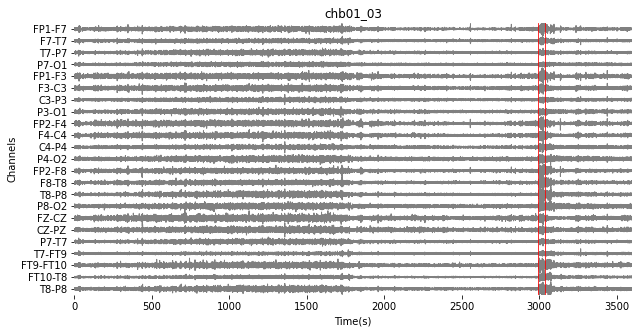

In [10]:
fig = plt.figure(figsize=(10,5))
ts = np.arange(0, len(x[0,:]))/rate
scale_ls = []

for i in range(n):
  f = pyedflib.EdfReader("/content/physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf")
  x[i,:] = f.readSignal(i)
  label = f.getLabel(i)
  f.close()

for i in range(n):
  plt.plot(ts, x[i,:]-i*800, linewidth=1, color='gray')
  scale_ls = scale_ls + [-i*800]

plt.xlim(0, dur)
plt.ylim(-18000, 400)
plt.yticks(scale_ls,signal_labels)
plt.xlabel("Time(s)")
plt.ylabel("Channels")
plt.title('chb01_03')

plt.axvline(2996, linestyle="-", linewidth=0.8, color='r') 
plt.axvline(3036, linestyle="-", linewidth=0.8, color='r') 

ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## Format of input files

```
----content\
    |----physionet.org\
    |    |----robots.txt
    |    |----files\
    |    |    |----chbmit\
    |    |    |    |----1.0.0\
    |    |    |    |    |----chb01\
    |    |    |    |    |    |----chb01-summary.txt
    |    |    |    |    |    |----chb01_01.edf
    |    |    |    |    |    |----chb01_02.edf
    |    |    |    |    |    |----...
    |    |    |    |    |----chb02\
    |    |    |    |    |    |----chb02-summary.txt
    |    |    |    |    |    |----...
    |    |    |    |    |----chb03\
    |    |    |    |    |    |----...
    |    |    |    |    |----chb04\
    |    |    |    |    |    |----...
    |    |    |    |    |----...
    |----chbfig\
    |    |----chb01\
    |    |    |----chb01_03_nonseizure_1263.jpg
    |    |    |----chb01_21_nonseizure_55.jpg
    |    |    |----chb01_03_seizure_3000.jpg
    |    |    |----...
    |    |----chb02\
    |    |    |----...
    |    |----chb03\
    |    |    |----...
    |    |----...
    |----cks\

```




# Helper Functions

Below global variables define the patient number we use for training and validation.

In [ ]:
pathDataSet = '/content/physionet.org/files/chbmit/1.0.0/'  # path of the dataset
patients = ["01","02","03","04","05","06","07","08","09","10"] # the record of the patients we use to train

This function read the files named `chbnn-summary.txt` which contain information about the montage used for each recording, and the elapsed time in seconds from the beginning of each .edf file to the beginning and end of each seizure contained in it.

In [ ]:
def loadSummaryPatient(index):
  f = open(pathDataSet+'chb'+patients[index]+'/chb'+patients[index]+'-summary.txt', 'r')
  parent = 'chb'+patients[index]+'/'
  return f, parent

This function helps generate seizure/nonseizure images according to the summary files. It reads in multi-channel EEG signals and output gray scale pictures. Treat the raw signal at each sample and channel as the pixel attribute of a 2D image, change it from time-amplitude domain to images domain. The rows corresponded to the different EEG channels aligned vertically, and the columns to the temporal dimension. Then split the time course of EEG signals into segments (windows) of 1 s of duration, so each resulting image had dimensions of *23 channels × ( 1 s × 256 samples/s )*.

The output image will be saved as a .jpg file and named after its corresponding patient number and time. 

In [ ]:
def seizureImageGenerate(secSt, secEn, name_F, parent):
  file1 = pyedflib.EdfReader(pathDataSet+parent+name_F)
  n = file1.signals_in_file
  # print(n)
  signal_labels = file1.getSignalLabels()
  signal_headers = file1.getSignalHeaders()
  rate = signal_headers[0]['sample_rate']
  dur = file1.getFileDuration()
  x = np.zeros((n, file1.getNSamples()[0]))
  for i in range(n):
    x[i,:] = file1.readSignal(i)
    # print(x)
    label = file1.getLabel(i)
  file1.close()
  #a = os.getcwd()
  path = '/content/chbfig/'+ parent
  if os.path.isdir(path) is not True:
    os.makedirs(path)
  picnum = int(dur*rate/256)
  for i in range(picnum):
    img = x[:,i*256:(i+1)*256]
    Img = Image.fromarray(np.uint8(img))
    if secSt <= i+1 <= secEn:
      filename = '_seizure_'+ str(i)
      Img.save(path + name_F.split('.')[0] + filename+'.jpg')
    else:
      filename = '_nonseizure_'+ str(i)
      Img.save(path + name_F.split('.')[0] + filename+'.jpg')

This function create the image dataset we use for training and validation.

In [ ]:
def createDataset():

    print("START \n")
    for indexPatient in range(0, len(patients)):
        # fileList = []
    
        f, parent = loadSummaryPatient(indexPatient)
        line=f.readline()
        while (line):
            data=line.split(':')
            if (data[0]=="File Name"):
                name_F=data[1].strip()
                print(name_F)
                for i in range(3):
                    line=f.readline()
                for j in range(0, int(line.split(': ')[1])):
                    secSt=int(f.readline().split(': ')[1].split(' ')[0])
                    secEn=int(f.readline().split(': ')[1].split(' ')[0])
                    seizureImageGenerate(secSt, secEn, name_F, parent)

            line=f.readline()
        f.close()

    print("END \n")

This function load features and labels for testing new patients and fine tune pre-trained model. For training and validation data loading, we use dataloader to help with memory outage.

In [ ]:
def testlabelGenerate():
    parent_path = 'chbfig/'
    featureList = []
    labelList = []
    for indexPatient in range(0, len(test_patients)):         # len(patients)
        sub_path = 'chb'+test_patients[indexPatient]+'/'
        print(sub_path)
        directory_name = parent_path+sub_path
        features = np.zeros((len(os.listdir(directory_name)),23,256))
        labels = np.zeros((len(os.listdir(directory_name))),dtype=int)
        i = 0 #the feature index
        for filename in os.listdir(directory_name):
            # print(filename)
            if '_seizure_' in filename:
                im_features = np.array(Image.open(directory_name+filename))
                features[i] = np.vstack((im_features[0:23,:], np.zeros(256)))[0:23,:]
                labels[i] = 1
            elif '_nonseizure_' in filename:
                im_features = np.array(Image.open(directory_name+filename))
                features[i] = np.vstack((im_features[0:23,:], np.zeros(256)))[0:23,:]
                labels[i] = 0
            i = i+1

        featureList.append(features)
        labelList.append(labels)

    X = featureList[0]
    Y = labelList[0]
    for j in range(1,len(featureList)):
        X = np.vstack((X,featureList[j]))
        Y = np.hstack((Y,labelList[j]))
  
    return X,Y

# Data Loader

In [ ]:
def generatePathList(patients, test_size):
    parent_path = 'chbfig/'
    pathList = []
    for indexPatient in range(0, len(patients)):
        sub_path = 'chb'+patients[indexPatient]+'/'
        directory_name = parent_path+sub_path
        for filename in os.listdir(directory_name):
            pathList.append(directory_name+filename)
    L = len(pathList)
    test_index = int(L*test_size)
    index = random.sample(range(L), L)
    return index[:test_index],index[test_index:],pathList


class DataGenerator(Sequence):

    def __init__(self, index, pathList, parent_path = 'chbfig/', batch_size=32):
        self.batch_size = batch_size
        self.parent_path = parent_path
        self.pathList = pathList
        self.index = index
        self.L = len(self.index)


    def __len__(self):
        return self.L - self.batch_size

    def __getitem__(self, idx):
        batch_indexs = self.index[idx:(idx+self.batch_size)]
        image_path = [self.pathList[k] for k in batch_indexs]
    
        return self._load_image(image_path)

  
    def _load_image(self, image_path):
        features = np.zeros(((len(image_path)),23,256))
        labels = np.zeros((len(image_path)),dtype=int)
        i = 0 #the feature index
        for name in image_path:
            #print(name)
            if '_seizure_' in name:
                features[i] = np.array(Image.open(name))[0:23,:]
                labels[i] = 1
            elif '_nonseizure_' in name:
                features[i] = np.array(Image.open(name))[0:23,:]
                labels[i] = 0
            i = i+1
        # print(features)
        # print(labels)
        # print(np.expand_dims(np.array(features), axis=3).shape)
        # print(labels.shape)
        return np.expand_dims(np.array(features), axis=3),labels


In [ ]:
# Use the data loader:
# test_id, train_id, path_list = generatePathList(patients,test_size=0.3)  # 30% test_size 
# train_data = DataGenerator(train_id, path_list)
# test_data = DataGenerator(test_id, path_list)

# Model Structure

This model combine FCN and Bi-directional GRU. The output of the 3rd 2Dconvolution is flattened and fed into Bi-directional GRU layer, then followed by 2 dense layer. The additional Bi-directional GRU is used for the purpose of f1-score improvement. 

In [ ]:
model = Sequential()

model.add(Conv2D(64, (2, 4), input_shape=((23, 256, 1))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.15))

model.add(Conv2D(32, (2, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.15))

model.add(Conv2D(32, (2, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.15))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(32)))
model.add(Dropout(0.15))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(metrics=['accuracy', [keras.metrics.FalseNegatives(name='FN')]], loss='binary_crossentropy', optimizer=sgd)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 253, 64)       576       
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 253, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 22, 253, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 63, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 60, 32)        16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 60, 32)        1

# Load pre-trained model

Our pre-trained model is trained and validated on AWS Sagemaker. Use seizure record from patient 01 to 10.

In [ ]:
model_test = keras.models.load_model('model_290-0.99.hdf5')

## Validation

Here we use seizure record from patient 01 to view the validation result of our model. The first 70% of the seizure record of patient 01 is already used for training, and the last 30% is used for the validation, so here we only load the validation set.

In [ ]:
patients = ["01"]  # You may change the patient number you want to validate (1-10)
createDataset()    # Due to the limited storage space of colab, here we only generate part of the data set
val_id, train_id, path_list = generatePathList(patients,test_size=0.3)
val_data = DataGenerator(val_id, path_list)

In [ ]:
model_test.evaluate(val_data, batch_size=32)

7145/7145 [==============================] - 133s 14ms/step - loss: 0.0204 - accuracy: 0.9933


[0.02044590190052986, 0.9932820200920105]

In [ ]:
y_hat = model_test.predict_classes(val_data)
y_val = []
for i in range(len(val_data)):
  list_val = list(val_data[i])
  y_val = np.hstack((y_val,list_val[1]))

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()
print('acuuracy \t', accuracy_score(y_val, y_hat))
sensitivity = int(tp)/int(tp+fn)
print('sensitivity \t', sensitivity)
specificity = int(tn)/int(fp+tn)
print('specificity \t', specificity)
print('F1-score \t', f1_score(y_val, y_hat)) 

acuuracy 	 0.9932820153953814
sensitivity 	 0.954248366013072
specificity 	 0.9941361556064073
F1-score 	 0.8588235294117648


## Fine Tune for new patient

We chose to divide the data set from the perspective of the patient instead of mixing the data of all patients. This is because we found that different patients have different seizure characteristics. Only when the model has learned the patient’s seizure data, The accuracy of the model is high. But when the model is used to test a new patient that it never learned, the detection rate is not ideal.

We did not find a solution to this problem in related papers. It seems that the papers used all patients' seizure data to train the model, and achieved high accuracy on these patients, but did not introduce new patients to verify. Therefore, we reserve some patients to evaluate the model before training.

The performance of the model on new patients is disappointing. So we try to fine tune the pre-train model use very few seizure data from new patient, the performance is improved a lot after 10 epochs.

We think this fine tune is reasonable, because the pathological characteristics of different patients are very different.

In [ ]:
test_patients = ["11"] # You may change the patient number you want to test (11-23)
patients = test_patients
createDataset()  # Due to the limited storage space of colab, here we only generate part of the data set

In [ ]:
test_features, test_labels = testlabelGenerate()
if test_features.ndim == 3:
    test_features = np.expand_dims(test_features, axis=3)

chb11/


In [ ]:
# train last 4 layers Bi-GRU and 2 dense layer
model_test.trainable = True    
for layer in model_test.layers[:16]:
    layer.trainable = False
model_test.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 22, 253, 64)       576       
_________________________________________________________________
batch_normalization_40 (Batc (None, 22, 253, 64)       256       
_________________________________________________________________
activation_40 (Activation)   (None, 22, 253, 64)       0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 22, 63, 64)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 22, 63, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 21, 60, 32)        16416     
_________________________________________________________________
batch_normalization_41 (Batc (None, 21, 60, 32)      

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(test_features, test_labels, test_size=0.4, random_state=1)
weights = collections.Counter(y_train)
weight = int(weights[0]/weights[1])

In [ ]:
# Before fine tune

y_hat = model_test.predict_classes(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print('acuuracy \t', accuracy_score(y_test, y_hat))
sensitivity = int(tp)/int(tp+fn)
print('sensitivity \t', sensitivity)
specificity = int(tn)/int(fp+tn)
print('specificity \t', specificity)
print('F1-score \t', f1_score(y_test, y_hat))

y_score = model_test.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_score) 

acuuracy 	 0.9537773359840954
sensitivity 	 0.5709677419354838
specificity 	 0.9857296715131934
F1-score 	 0.6555555555555554


|     | accuracy | sensitivity | specificity | f1-score |
| ------ | -------- | ----------- | ----------- | -------- |
| chb11 | 0.9537773359840954 | 0.5709677419354838 | 0.9857296715131934 | 0.6555555555555554
| chb12 | 0.4794585987261146 | 0.7475083056478405 | 0.4706108125890997 | 0.08405715886803027
| chb13 | 0.8144365290533001 | 0.23783783783783785 | 0.8237397523111809 | 0.03911111111111111
| chb14 | 0.9217666864725689 | 0.03896103896103896 | 0.928550044905698 | 0.007537688442211056
| chb15 | 0.9533666079467606 | 0.031839622641509434 | 0.9932611803144783 | 0.05362462760675273
| chb16 | 0.9679020898279644 | 0.22857142857142856 | 0.9709019244145606 | 0.05442176870748299
| chb17 | 0.9755196304849885 | 0.2037037037037037 | 0.9952629085741355 | 0.2933333333333333
| chb18 | 0.9844636251541307 | 0.2698412698412698 | 0.9957414829659319 | 0.3505154639175258
| chb19 | 0.9741644939559138 | 0.36538461538461536 | 0.98955042527339 | 0.41081081081081083
| chb20 | 0.9810596682347116 | 0.2 | 0.9923395705136255 | 0.23115577889447236
| chb21 | 0.9738941261783901 | 0.04395604395604396 | 0.9894930875576037 | 0.05263157894736843
| chb22 | 0.9648148148148148 | 0.8484848484848485 | 0.9666196520921486 | 0.42424242424242425
| chb23 | 0.9536418758154885 | 0.8606060606060606 | 0.9548351990049752 | 0.31981981981981983

In [ ]:
seed(1)
model_test.fit(x_train, y_train, batch_size=32, epochs=10, class_weight = {0:1, 1:weight}, shuffle=False) 

Epoch 1/10
189/189 [==============================] - 18s 87ms/step - loss: 0.6567 - accuracy: 0.9269
Epoch 2/10
189/189 [==============================] - 16s 87ms/step - loss: 0.3952 - accuracy: 0.9382
Epoch 3/10
189/189 [==============================] - 16s 87ms/step - loss: 0.3229 - accuracy: 0.9471
Epoch 4/10
189/189 [==============================] - 16s 86ms/step - loss: 0.2782 - accuracy: 0.9508
Epoch 5/10
189/189 [==============================] - 16s 86ms/step - loss: 0.2448 - accuracy: 0.9538
Epoch 6/10
189/189 [==============================] - 16s 87ms/step - loss: 0.2298 - accuracy: 0.9571
Epoch 7/10
189/189 [==============================] - 16s 86ms/step - loss: 0.2130 - accuracy: 0.9617
Epoch 8/10
189/189 [==============================] - 16s 86ms/step - loss: 0.1761 - accuracy: 0.9659
Epoch 9/10
189/189 [==============================] - 16s 84ms/step - loss: 0.2034 - accuracy: 0.9602
Epoch 10/10
189/189 [==============================] - 16s 86ms/step - loss: 0.156

In [ ]:
# After fine tune

y_hat = model_test.predict_classes(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print('acuuracy \t', accuracy_score(y_test, y_hat))
sensitivity = int(tp)/int(tp+fn)
print('sensitivity \t', sensitivity)
specificity = int(tn)/int(fp+tn)
print('specificity \t', specificity)
print('F1-score \t', f1_score(y_test, y_hat))

y_score = model_test.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_score) 

acuuracy 	 0.9699304174950298
sensitivity 	 0.9612903225806452
specificity 	 0.9706515885837372
F1-score 	 0.8312412831241283


|     | accuracy | sensitivity | specificity | f1-score |
| ------ | -------- | ----------- | ----------- | -------- |
| chb11 | 0.9699304174950298 | 0.9612903225806452 | 0.9706515885837372 | 0.8312412831241283
| chb12 | 0.8904989384288747 | 0.584717607973422 | 0.9005921701941002 | 0.2544271774485002
| chb13 | 0.7853403141361257 | 0.9081081081081082 | 0.783359497645212 | 0.11843496651392316
| chb14 | 0.9358288770053476 | 0.7792207792207793 | 0.9370322323121445 | 0.15625
| chb15 | 0.9583577999608534 | 0.8950471698113207 | 0.9610986318153972 | 0.6407766990291263
| chb16 | 0.9715968133010046 | 0.5142857142857142 | 0.9734523533503362 | 0.1276595744680851
| chb17 | 0.910161662817552 | 0.8981481481481481 | 0.9104689720511606 | 0.33276157804459694
| chb18 | 0.9025893958076449 | 0.9047619047619048 | 0.9025551102204409 | 0.2239685658153242
| chb19 | 0.9341076084380184 | 0.9230769230769231 | 0.9343863912515188 | 0.4085106382978723
| chb20 | 0.9372369398365932 | 0.9304347826086956 | 0.9373351751852317 | 0.2968099861303744
| chb21 | 0.8934010152284264 | 0.9010989010989011 | 0.8932718894009216 | 0.21808510638297873
| chb22 | 0.9756944444444444 | 0.9848484848484849 | 0.9755524212505877 | 0.5531914893617023
| chb23 | 0.9537953795379538 | 0.9818181818181818 | 0.9534359452736318 | 0.3498920086393089

     AUC     	 0.994701825698751


<Figure size 432x288 with 0 Axes>

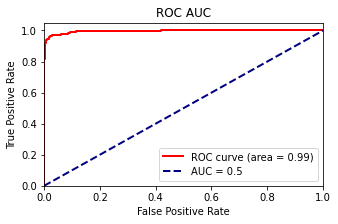

In [ ]:
confusion_matrix(y_test, y_hat).ravel()
roc_auc = auc(fpr, tpr)    
print('     AUC     \t', roc_auc)
plt.figure()

plt.figure(figsize=(5, 3))
A, = plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
B, = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='AUC = 0.5')

legend = plt.legend(handles=[A, B], loc="lower right")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC AUC')
plt.show()